In [5]:
# Celda 1: Importaciones y Configuración del Benchmark para MPI

import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import platform
import re # Importamos el módulo de expresiones regulares para parsear
from tqdm import tqdm
import numpy as np

# --- CONFIGURACIÓN DE LA PRUEBA MPI ---

# 1. Carpeta para guardar todos los resultados
EXPERIMENT_DIR = "experimentos"

# 2. Parámetros de la malla y los procesos
GRID_LENGTH = "100"
NPROCS_LIST = [1, 2, 4, 8, 16]

# 3. Implementaciones de MPI a probar
MPI_BINARIES = [
    "yee_blocking_mpi",
    "yee_nonblock_mpi"
]

# 4. Prefijo que tu programa imprime antes del tiempo. ¡IMPORTANTE!
#    El script buscará una línea que empiece con esto.
TIME_OUTPUT_PREFIX = "Elapsed:"

# 5. Número de repeticiones (si quieres promediar).
#    Si tu programa ya es muy estable, puedes dejarlo en 1.
REPETICIONES = 3

# 6. Detección de la carpeta de binarios y nombres de archivos
ARCHNAME = f"{platform.system()}_{platform.machine()}"
BIN_DIR = f"{ARCHNAME}/bin"
OUTPUT_CSV_MPI = os.path.join(EXPERIMENT_DIR, f"resultados_mpi_grid{GRID_LENGTH}.csv")
OUTPUT_PNG_TIME_MPI = os.path.join(EXPERIMENT_DIR, f"rendimiento_mpi_grid{GRID_LENGTH}.png")
OUTPUT_PNG_SPEEDUP_MPI = os.path.join(EXPERIMENT_DIR, f"speedup_mpi_grid{GRID_LENGTH}.png")

# --- PREPARACIÓN DEL ENTORNO ---
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

print("--- Configuración para MPI Cargada ---")
print("¡Listo para compilar en la siguiente celda!")

--- Configuración para MPI Cargada ---
¡Listo para compilar en la siguiente celda!


In [6]:
# Celda 2: Compilar los Ejecutables (Versión Universal)

print(f"=== Compilando todos los ejecutables en '{BIN_DIR}'... ===")
# La variable BIN_DIR fue definida en la Celda 1

try:
    # 'make bin' compila todos los binarios definidos en el Makefile.
    # Es la forma más robusta y no depende de variables de Python.
    result = subprocess.run(["make", "bin"], check=True, capture_output=True, text=True)
    print("¡Compilación completada exitosamente!")
    
    # Después de esta celda, la Celda 3 se encargará de verificar
    # si los binarios específicos que necesita (MPI_BINARIES) existen.
    # No es necesario verificarlos aquí.

except FileNotFoundError:
    print("ERROR: El comando 'make' no se encontró. ¿Está instalado y en el PATH de tu entorno WSL?")
except subprocess.CalledProcessError as e:
    print("ERROR: 'make bin' falló. Revisa tu Makefile o el código fuente.")
    print("--- Salida de Error de 'make' ---")
    print(e.stderr)
    print("---------------------------------")

=== Compilando todos los ejecutables en 'Linux_x86_64/bin'... ===
¡Compilación completada exitosamente!


In [7]:
# Celda 3: Ejecutar Benchmark MPI, Capturar y Parsear Tiempos (Versión Final)

all_results_mpi = []
fallos_totales = 0

total_runs = len(MPI_BINARIES) * len(NPROCS_LIST) * REPETICIONES
progress_bar = tqdm(total=total_runs, desc="Ejecutando pruebas MPI", unit="run")

def parse_time_from_output(output: str, prefix: str) -> float | None:
    """Busca y extrae el tiempo de la salida de texto del programa."""
    for line in output.splitlines():
        if line.strip().startswith(prefix):
            try:
                time_str = line.split()[1]
                return float(time_str)
            except (IndexError, ValueError):
                return None
    return None

for binary_name in MPI_BINARIES:
    executable_path = os.path.join(BIN_DIR, binary_name)
    if not os.path.exists(executable_path):
        print(f"SALTANDO: {binary_name} no se encontró en {executable_path}")
        progress_bar.update(len(NPROCS_LIST) * REPETICIONES)
        continue
        
    for n_procs in NPROCS_LIST:
        for i in range(REPETICIONES):
            # --- Comando modificado con la opción correcta ---
            command = [
                "mpirun",
                "--use-hwthread-cpus", # <-- Le dice a MPI que use los 16 hilos como slots
                "-np", str(n_procs),
                executable_path,
                "-n", GRID_LENGTH
            ]
            
            try:
                result = subprocess.run(
                    command,
                    capture_output=True,
                    text=True,
                    check=True
                )
                elapsed = parse_time_from_output(result.stdout, TIME_OUTPUT_PREFIX)
                if elapsed is None:
                    print(f"\n¡ADVERTENCIA! No se encontró el tiempo en la salida para '{' '.join(command)}'")
                    print("Salida recibida:\n", result.stdout)
                    fallos_totales += 1

            except subprocess.CalledProcessError as e:
                print(f"\n¡FALLO! El comando '{' '.join(command)}' devolvió un error.")
                print("Stderr:", e.stderr)
                elapsed = None
                fallos_totales += 1
            
            all_results_mpi.append({
                "binary": binary_name,
                "processes": n_procs,
                "run": i + 1,
                "time_s": elapsed
            })
            progress_bar.update(1)
            progress_bar.set_postfix_str(f"{binary_name} @ {n_procs} procs")

progress_bar.close()
print(f"\n¡Benchmark MPI completado con {fallos_totales} fallos o advertencias!")

df_raw_mpi = pd.DataFrame(all_results_mpi)
df_raw_mpi = df_raw_mpi.dropna(subset=['time_s'])

if df_raw_mpi.empty:
    print("\n¡ERROR FATAL! No se pudo recolectar ningún dato de tiempo válido.")
else:
    print("\nMuestra de los tiempos medidos:")
    display(df_raw_mpi.head())

Ejecutando pruebas MPI:  60%|▌| 18/30 [06:52<04:35, 22.93s/run, yee_nonblock_mpi
Ejecutando pruebas MPI:  43%|▍| 13/30 [00:05<00:07,  2.26run/s, yee_blocking_mpi


¡FALLO! El comando 'mpirun --use-hwthread-cpus -np 16 Linux_x86_64/bin/yee_blocking_mpi -n 100' devolvió un error.
Stderr: [kevin-MS-7A38:13198] *** An error occurred in MPI_Send
[kevin-MS-7A38:13198] *** reported by process [3465347073,0]
[kevin-MS-7A38:13198] *** on communicator MPI_COMM_WORLD
[kevin-MS-7A38:13198] *** MPI_ERR_COUNT: invalid count argument
[kevin-MS-7A38:13198] *** MPI_ERRORS_ARE_FATAL (processes in this communicator will now abort,
[kevin-MS-7A38:13198] ***    and potentially your MPI job)
Memory allocation failed



Ejecutando pruebas MPI:  47%|▍| 14/30 [00:06<00:07,  2.26run/s, yee_blocking_mpi


¡FALLO! El comando 'mpirun --use-hwthread-cpus -np 16 Linux_x86_64/bin/yee_blocking_mpi -n 100' devolvió un error.
Stderr: [kevin-MS-7A38:13260] *** An error occurred in MPI_Send
[kevin-MS-7A38:13260] *** reported by process [3467771905,0]
[kevin-MS-7A38:13260] *** on communicator MPI_COMM_WORLD
[kevin-MS-7A38:13260] *** MPI_ERR_COUNT: invalid count argument
[kevin-MS-7A38:13260] *** MPI_ERRORS_ARE_FATAL (processes in this communicator will now abort,
[kevin-MS-7A38:13260] ***    and potentially your MPI job)
Memory allocation failed



Ejecutando pruebas MPI:  50%|▌| 15/30 [00:06<00:06,  2.22run/s, yee_blocking_mpi


¡FALLO! El comando 'mpirun --use-hwthread-cpus -np 16 Linux_x86_64/bin/yee_blocking_mpi -n 100' devolvió un error.
Stderr: Memory allocation failed
[kevin-MS-7A38:13322] *** An error occurred in MPI_Send
[kevin-MS-7A38:13322] *** reported by process [3471900673,0]
[kevin-MS-7A38:13322] *** on communicator MPI_COMM_WORLD
[kevin-MS-7A38:13322] *** MPI_ERR_COUNT: invalid count argument
[kevin-MS-7A38:13322] *** MPI_ERRORS_ARE_FATAL (processes in this communicator will now abort,
[kevin-MS-7A38:13322] ***    and potentially your MPI job)



Ejecutando pruebas MPI:  93%|▉| 28/30 [00:12<00:00,  2.24run/s, yee_nonblock_mpi


¡FALLO! El comando 'mpirun --use-hwthread-cpus -np 16 Linux_x86_64/bin/yee_nonblock_mpi -n 100' devolvió un error.
Stderr: [kevin-MS-7A38:13673] *** An error occurred in MPI_Send
[kevin-MS-7A38:13673] *** reported by process [3360686081,0]
[kevin-MS-7A38:13673] *** on communicator MPI_COMM_WORLD
[kevin-MS-7A38:13673] *** MPI_ERR_COUNT: invalid count argument
[kevin-MS-7A38:13673] *** MPI_ERRORS_ARE_FATAL (processes in this communicator will now abort,
[kevin-MS-7A38:13673] ***    and potentially your MPI job)
Memory allocation failed



Ejecutando pruebas MPI:  97%|▉| 29/30 [00:12<00:00,  2.25run/s, yee_nonblock_mpi


¡FALLO! El comando 'mpirun --use-hwthread-cpus -np 16 Linux_x86_64/bin/yee_nonblock_mpi -n 100' devolvió un error.
Stderr: [kevin-MS-7A38:13734] *** An error occurred in MPI_Send
[kevin-MS-7A38:13734] *** reported by process [3365142529,0]
[kevin-MS-7A38:13734] *** on communicator MPI_COMM_WORLD
[kevin-MS-7A38:13734] *** MPI_ERR_COUNT: invalid count argument
[kevin-MS-7A38:13734] *** MPI_ERRORS_ARE_FATAL (processes in this communicator will now abort,
[kevin-MS-7A38:13734] ***    and potentially your MPI job)
Memory allocation failed



Ejecutando pruebas MPI: 100%|█| 30/30 [00:13<00:00,  2.26run/s, yee_nonblock_mpi


¡FALLO! El comando 'mpirun --use-hwthread-cpus -np 16 Linux_x86_64/bin/yee_nonblock_mpi -n 100' devolvió un error.
Stderr: Memory allocation failed
[kevin-MS-7A38:13794] *** An error occurred in MPI_Send
[kevin-MS-7A38:13794] *** reported by process [3369795585,0]
[kevin-MS-7A38:13794] *** on communicator MPI_COMM_WORLD
[kevin-MS-7A38:13794] *** MPI_ERR_COUNT: invalid count argument
[kevin-MS-7A38:13794] *** MPI_ERRORS_ARE_FATAL (processes in this communicator will now abort,
[kevin-MS-7A38:13794] ***    and potentially your MPI job)


¡Benchmark MPI completado con 6 fallos o advertencias!

Muestra de los tiempos medidos:


,binary,processes,run,time_s
0,yee_blocking_mpi,1,1,0.002569
1,yee_blocking_mpi,1,2,0.002557
2,yee_blocking_mpi,1,3,0.002559
3,yee_blocking_mpi,2,1,0.002606
4,yee_blocking_mpi,2,2,0.002582


Resultados MPI crudos guardados en 'experimentos/resultados_mpi_grid100.csv'

Tiempos de ejecución MPI promediados:


,binary,processes,time_s
0,yee_blocking_mpi,1,0.002562
1,yee_blocking_mpi,2,0.002589
2,yee_blocking_mpi,4,0.002093
3,yee_blocking_mpi,8,0.001873
4,yee_nonblock_mpi,1,0.002474
5,yee_nonblock_mpi,2,0.002542
6,yee_nonblock_mpi,4,0.002964
7,yee_nonblock_mpi,8,0.001962



Generando gráfica de rendimiento MPI y guardando en 'experimentos/rendimiento_mpi_grid100.png'...


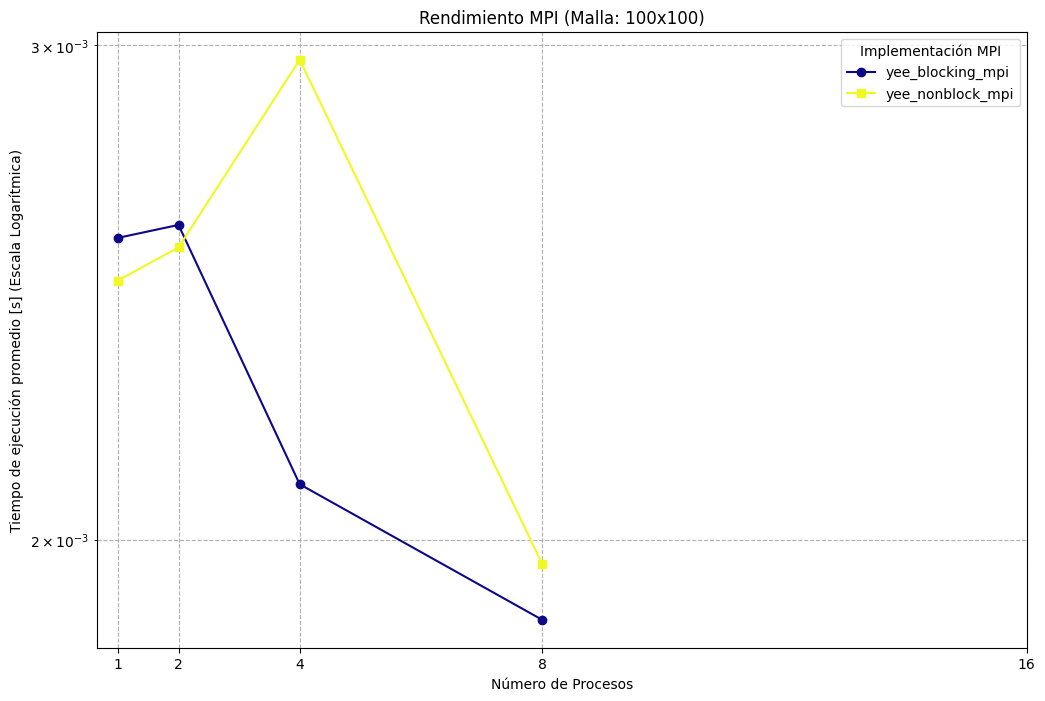

Tabla de Speedup MPI:


,binary,processes,time_s,speedup
0,yee_blocking_mpi,1,0.002562,1.000000
1,yee_blocking_mpi,2,0.002589,0.989443
2,yee_blocking_mpi,4,0.002093,1.223726
3,yee_blocking_mpi,8,0.001873,1.367438
4,yee_nonblock_mpi,1,0.002474,1.000000
5,yee_nonblock_mpi,2,0.002542,0.973246
6,yee_nonblock_mpi,4,0.002964,0.834477
7,yee_nonblock_mpi,8,0.001962,1.261003



Generando gráfica de speedup MPI y guardando en 'experimentos/speedup_mpi_grid100.png'...


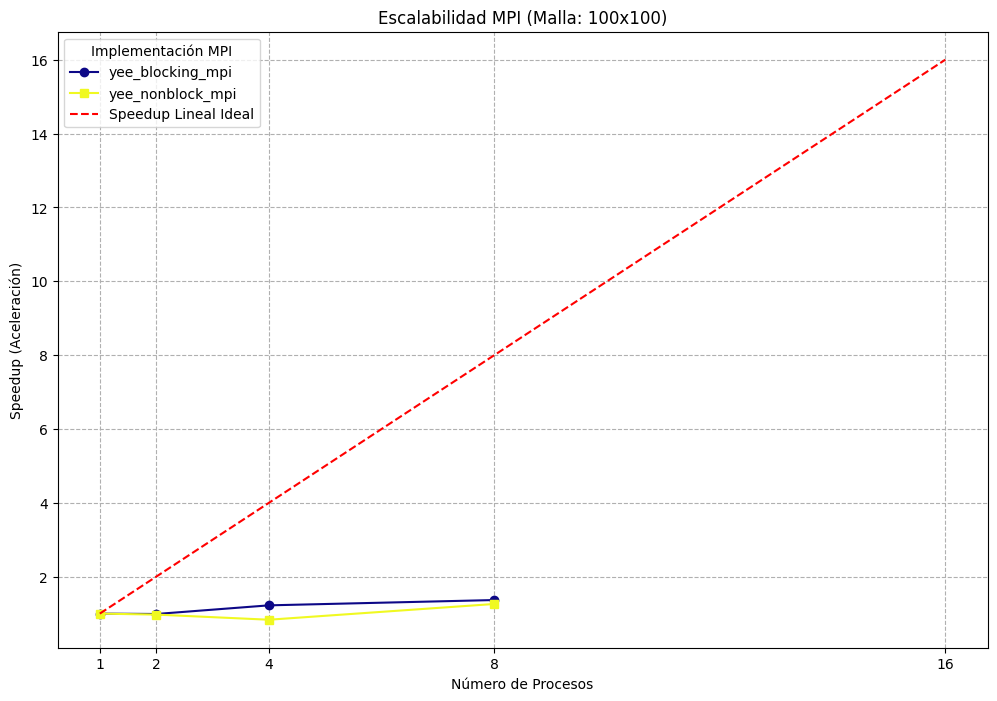

In [8]:
# Celda 4: Procesar Datos MPI y Generar Gráfica de Tiempo vs. Procesos

if 'df_raw_mpi' in locals() and not df_raw_mpi.empty:
    df_raw_mpi.to_csv(OUTPUT_CSV_MPI, index=False)
    print(f"Resultados MPI crudos guardados en '{OUTPUT_CSV_MPI}'")

    df_mean_mpi = df_raw_mpi.groupby(["binary", "processes"])["time_s"].mean().reset_index()

    print("\nTiempos de ejecución MPI promediados:")
    display(df_mean_mpi)

    print(f"\nGenerando gráfica de rendimiento MPI y guardando en '{OUTPUT_PNG_TIME_MPI}'...")
    fig, ax = plt.subplots(figsize=(12, 8))
    # ... (el resto del código de ploteo es idéntico, solo cambia 'threads' por 'processes')
    colors = plt.cm.plasma(np.linspace(0, 1, len(MPI_BINARIES)))
    markers = ['o', 's']
    for i, binary_name in enumerate(MPI_BINARIES):
        subset = df_mean_mpi[df_mean_mpi["binary"] == binary_name]
        ax.plot(subset["processes"], subset["time_s"], marker=markers[i], linestyle='-', color=colors[i], label=binary_name)

    ax.set_xlabel("Número de Procesos")
    ax.set_ylabel("Tiempo de ejecución promedio [s] (Escala Logarítmica)")
    ax.set_title(f"Rendimiento MPI (Malla: {GRID_LENGTH}x{GRID_LENGTH})")
    ax.set_xticks(NPROCS_LIST)
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='--')
    ax.legend(title="Implementación MPI")
    plt.savefig(OUTPUT_PNG_TIME_MPI, dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No se generaron resultados MPI válidos.")# Celda 5: Calcular y Graficar el Speedup de MPI

if 'df_mean_mpi' in locals() and not df_mean_mpi.empty:
    df_speedup_mpi = pd.DataFrame()
    for binary_name in MPI_BINARIES:
        subset = df_mean_mpi[df_mean_mpi["binary"] == binary_name].copy()
        time_1_proc = subset[subset["processes"] == 1]["time_s"].iloc[0]
        subset["speedup"] = time_1_proc / subset["time_s"]
        df_speedup_mpi = pd.concat([df_speedup_mpi, subset])
        
    print("Tabla de Speedup MPI:")
    display(df_speedup_mpi)

    print(f"\nGenerando gráfica de speedup MPI y guardando en '{OUTPUT_PNG_SPEEDUP_MPI}'...")
    fig, ax = plt.subplots(figsize=(12, 8))
    # ... (el resto del código de ploteo es idéntico)
    colors = plt.cm.plasma(np.linspace(0, 1, len(MPI_BINARIES)))
    markers = ['o', 's']
    for i, binary_name in enumerate(MPI_BINARIES):
        subset = df_speedup_mpi[df_speedup_mpi["binary"] == binary_name]
        ax.plot(subset["processes"], subset["speedup"], marker=markers[i], linestyle='-', color=colors[i], label=binary_name)
    
    ax.plot(NPROCS_LIST, NPROCS_LIST, linestyle='--', color='red', label='Speedup Lineal Ideal')
    ax.set_xlabel("Número de Procesos")
    ax.set_ylabel("Speedup (Aceleración)")
    ax.set_title(f"Escalabilidad MPI (Malla: {GRID_LENGTH}x{GRID_LENGTH})")
    ax.set_xticks(NPROCS_LIST)
    ax.grid(True, which="both", linestyle='--')
    ax.legend(title="Implementación MPI")
    plt.savefig(OUTPUT_PNG_SPEEDUP_MPI, dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No se generaron resultados MPI válidos para calcular el speedup.")

In [ ]:
# Celda 6 (MPI): Benchmark de Tamaño de Malla con 8 Procesos

print("\n--- INICIANDO BENCHMARK DE TAMAÑO DE MALLA (MPI) ---")

# --- Configuración para esta prueba ---
NPROCS_FIXED_MPI = 8
GRID_LENGTH_LIST_MPI = np.arange(500, 1010, 50)
REPETICIONES_GRID_MPI = 1
OUTPUT_CSV_GRIDSIZE_MPI = os.path.join(EXPERIMENT_DIR, f"resultados_gridsize_mpi_n{NPROCS_FIXED_MPI}.csv")

results_grid_mpi = []
total_runs = len(MPI_BINARIES) * len(GRID_LENGTH_LIST_MPI) * REPETICIONES_GRID_MPI
progress_bar = tqdm(total=total_runs, desc=f"MPI @ {NPROCS_FIXED_MPI} procesos", unit="run")

# Bucle principal sobre el tamaño de la malla
for grid_length in GRID_LENGTH_LIST_MPI:
    grid_length_str = str(grid_length)
    for binary_name in MPI_BINARIES:
        for i in range(REPETICIONES_GRID_MPI):
            executable_path = os.path.join(BIN_DIR, binary_name)
            command = ["mpirun", "--use-hwthread-cpus", "-np", str(NPROCS_FIXED_MPI), executable_path, "-n", grid_length_str]
            
            try:
                result = subprocess.run(command, check=True, capture_output=True, text=True)
                elapsed = parse_time_from_output(result.stdout) # Usamos la función de parseo que ya existe en la Celda 3
                if elapsed is not None:
                    results_grid_mpi.append({"binary": binary_name, "grid_size": grid_length, "time_s": elapsed})
            except Exception as e:
                print(f"Fallo en {binary_name} con malla {grid_length}: {e}")
            progress_bar.update(1)

progress_bar.close()

# Guardar resultados
if results_grid_mpi:
    df_grid_mpi = pd.DataFrame(results_grid_mpi)
    df_grid_mpi.to_csv(OUTPUT_CSV_GRIDSIZE_MPI, index=False)
    print(f"\nResultados de tamaño de malla para MPI guardados en '{OUTPUT_CSV_GRIDSIZE_MPI}'")
    display(df_grid_mpi.head())
else:
    print("\nNo se recolectaron datos para el benchmark de tamaño de malla de MPI.")